In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
import scipy.stats as sts

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
# reflect the tables
conn = engine.connect()
Base=automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

In [12]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
result = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(result.statement, session.bind) 
# Sort the dataframe by date
df = df.sort_values(by='date', ascending = True)
df.set_index('date', inplace=True)

Text(0.5, 1.0, 'Precipitation Data from 082316-082317')

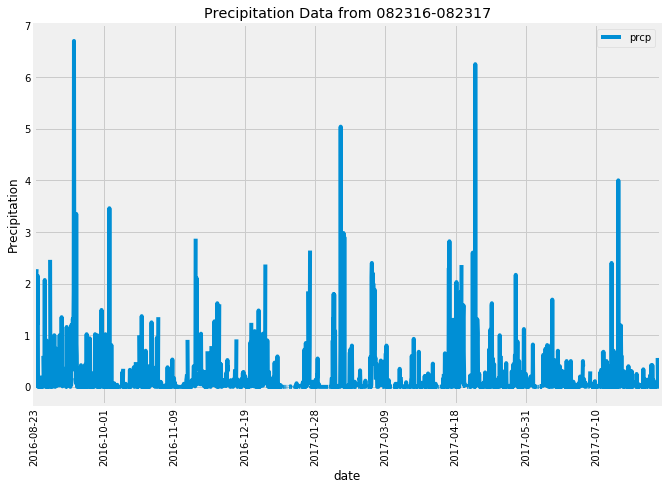

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
#plot data
fig, ax = plt.subplots(figsize=(10,7))
df.plot(ax=ax)
plt.xticks(rotation='vertical')
plt.ylabel('Precipitation')
plt.title('Precipitation Data from 082316-082317')

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(measurement.station.distinct())).first()

(9)

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
result = session.query(measurement.station, func.count(measurement.station)).\
         group_by(measurement.station).\
         order_by(func.count(measurement.station).desc()).all()
result

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest = session.query(func.max(measurement.prcp)).filter(measurement.station=='USC00519281').all()
lowest = session.query(func.min(measurement.prcp)).filter(measurement.station=='USC00519281').all()
avg = session.query(func.avg(measurement.prcp)).filter(measurement.station=='USC00519281').all()

Text(0.5, 1.0, 'Histogram For Station ID USC00519281')

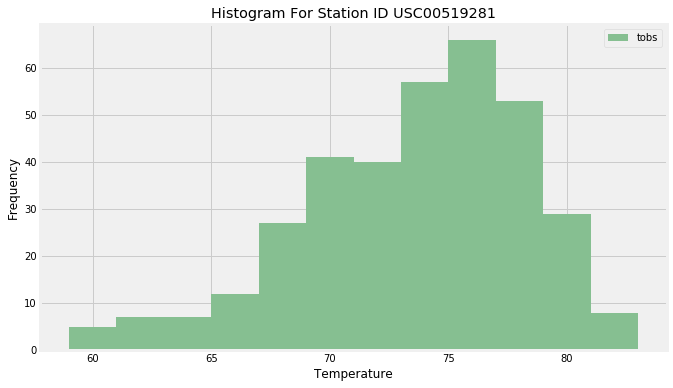

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result = session.query(measurement.date, measurement.tobs).filter(measurement.station=='USC00519281').\
         filter(measurement.date >= year_ago)
temp_df = pd.read_sql(result.statement, session.bind)
temp_df[['tobs']].plot(kind='hist', bins=12, figsize = (10,6), color='#86bf91')
plt.xlabel('Temperature')
plt.title('Histogram For Station ID USC00519281')

## Bonus Challenge Assignment

In [19]:
temp_df = pd.read_csv("Resources/hawaii_measurements.csv")
temp_df['date'] = pd.to_datetime(temp_df['date'])

In [20]:
june_df = temp_df[temp_df['date'].dt.month == 6]
june_df

,station,date,prcp,tobs
133,USC00519397,2010-06-01,0.00,78
134,USC00519397,2010-06-02,0.01,76
135,USC00519397,2010-06-03,0.00,78
136,USC00519397,2010-06-04,0.00,76
137,USC00519397,2010-06-05,0.00,77
...,...,...,...,...
19492,USC00516128,2017-06-26,0.02,79
19493,USC00516128,2017-06-27,0.10,74
19494,USC00516128,2017-06-28,0.02,74
19495,USC00516128,2017-06-29,0.04,76


In [21]:
june_df['tobs'].mean()

74.94411764705882

In [22]:
dec_df = temp_df[temp_df['date'].dt.month == 12]
dec_df

,station,date,prcp,tobs
305,USC00519397,2010-12-01,0.04,76
306,USC00519397,2010-12-03,0.00,74
307,USC00519397,2010-12-04,0.00,74
308,USC00519397,2010-12-06,0.00,64
309,USC00519397,2010-12-07,0.00,64
...,...,...,...,...
19323,USC00516128,2016-12-27,0.14,71
19324,USC00516128,2016-12-28,0.14,71
19325,USC00516128,2016-12-29,1.03,69
19326,USC00516128,2016-12-30,2.37,65


In [23]:
dec_df['tobs'].mean()

71.04152933421226

In [24]:
sts.ttest_1samp(june_df['tobs'], temp_df['tobs'].mean())

Ttest_1sampResult(statistic=23.367986800334165, pvalue=5.9381384599088085e-105)

In [25]:
sts.ttest_1samp(dec_df['tobs'], temp_df['tobs'].mean())

Ttest_1sampResult(statistic=-21.381940138951986, pvalue=7.252973105747039e-89)

<strong>Both p-values were less than 0.05, therefore, average temperatures in June and December were determined to be statistically different from the population mean. Paired t-test is used here because both samples consisted of the same test subjects (stations in this case).</strong>

In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [52]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date_prev = dt.date(2018, 1, 1) - dt.timedelta(days=365)
end_date_prev = dt.date(2018, 1, 7) - dt.timedelta(days=365)
result = calc_temps(start_date_prev, end_date_prev)
result = list(np.ravel(result))
[Tmin, Tavg, Tmax] = result

Text(0.5, 1.0, 'Trip Avg Temp')

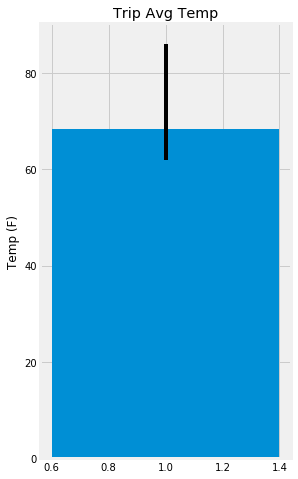

In [80]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
figsize = plt.figaspect(2)
fig, ax = plt.subplots(figsize=figsize)
YERR = Tmax - Tmin
plt.errorbar(1, Tmax, yerr= YERR, color='black')
ax.bar(1, Tavg)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')

In [124]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
rainfall = temp_df.loc[(temp_df['date'] >= start_date_prev) & (temp_df['date'] <= end_date_prev), ['station','prcp']].\
           groupby(temp_df['station']).sum()
rainfall

C:\Users\hongy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


,prcp
station,
USC00513117,0.35
USC00514830,0.60
USC00516128,0.60
USC00519281,0.20
USC00519397,0.00
USC00519523,0.61


In [125]:
station_info = pd.read_csv("Resources/hawaii_stations.csv")
station_info

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [126]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
combined_df = pd.merge(station_info, rainfall, on='station', how='right')
combined_df.sort_values(['prcp'], ascending=False)

,station,name,latitude,longitude,elevation,prcp
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.60
5,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.60
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.20
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


In [127]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [201]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

start_date = dt.date(2018, 1, 1)
end_date = dt.date(2018, 1, 7)
mydates = pd.date_range(start_date, end_date).tolist()
normals = []
for date in mydates:
    date = date.strftime("%m-%d")
    result = daily_normals(date)
    result = list(np.ravel(result))
    normals.append(result)
normals

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0]]

In [212]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
query_df = pd.DataFrame({'date': mydates,
                         'Tmin': [normals[0][0], normals[1][0], normals[2][0], normals[3][0], normals[4][0], normals[5][0], normals[6][0]],
                         'Tavg': [normals[0][1], normals[1][1], normals[2][1], normals[3][1], normals[4][1], normals[5][1], normals[6][1]],
                         'Tmax': [normals[0][2], normals[1][2], normals[2][2], normals[3][2], normals[4][2], normals[5][2], normals[6][2]]})
query_df.set_index('date', inplace=True)

Text(0, 0.5, 'Temperature')

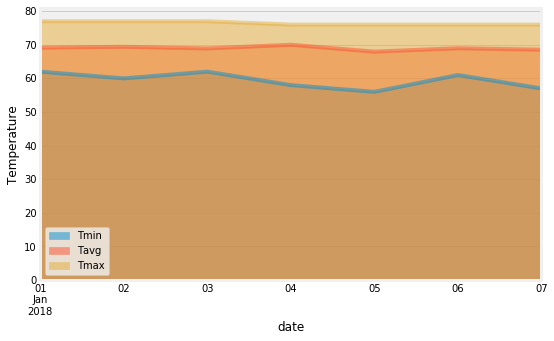

In [219]:
# Plot the daily normals as an area plot with `stacked=False`
query_df.plot.area(figsize=(8,5), stacked=False)
plt.ylabel('Temperature')